In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.tensor(1).cuda()

cuda:0


tensor(1, device='cuda:0')

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        # 定义网络层
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #3：输入channel，6输出channel，5：kernel size
        self.pool = nn.MaxPool2d(2, 2)  #2：kernel size，2：stride
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 定义前向网络结构
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # 打平tensor，-1表示任意size
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device)  

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

torch.Size([4, 3, 32, 32])


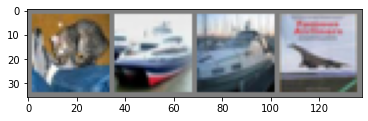

GroundTruth:    cat  ship  ship plane


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# 该函数可视化一张图片
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(testloader)
images, labels = dataiter.next()
print(images.size())

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

## torch2onnx

In [5]:
half = True  # True if FP16,False if FP32
path = 'cifar.pt'  # trained with pytorch_cifar10.ipynb

model = torch.load(path)
model.eval()
if half:
    model = model.to(device).half()
    img = images.to(device).half()
else:
    model = model.to(device)
    img = images.to(device)

In [6]:
img.shape

torch.Size([4, 3, 32, 32])

In [7]:
import os
onnx_path = './model_repository/model_test/1'
if not os.path.exists(onnx_path):
    os.makedirs(onnx_path)
f = os.path.join(onnx_path, 'model.onnx')
torch.onnx.export(model, img, f,
verbose=False, 
opset_version=12,
training=False,
do_constant_folding=False,
input_names=['images'],
output_names=['output'],
dynamic_axes={'images': {0: 'batch', 2: 'height', 3: 'width'},# shape(1,3,640,640)
'output': {0: 'batch', 1: 'anchors'}# shape(1,25200,85)
} 
)

In [8]:
import onnx
model_onnx = onnx.load(f)
# onnx.checker.check_model(model_onnx)
print(model_onnx.graph.output)

[name: "output"
type {
  tensor_type {
    elem_type: 10
    shape {
      dim {
        dim_param: "batch"
      }
      dim {
        dim_param: "anchors"
      }
    }
  }
}
]


## triton服务启动及配置
以下3个步骤参考triton.md
* 启动triton服务
* 配置config文件
* 重启triton服务

## 同步调用

###  triton 推理

In [9]:
import cv2
import time
import numpy as np
np.set_printoptions(suppress=True)
import tritonclient.grpc as grpcclient

triton_client = grpcclient.InferenceServerClient(url='127.0.0.1:8001', verbose=False)  # 固定不用改
outputs = [grpcclient.InferRequestedOutput('output'),]

if half:    
    img = images.cpu().half().numpy()
    inputs = [grpcclient.InferInput('images', img.shape, 'FP16')]
else:
    img = images.cpu().numpy()
    inputs = [grpcclient.InferInput('images', img.shape, 'FP32')]
inputs[0].set_data_from_numpy(img)

start_time = time.time()
result = triton_client.infer(
'model_test',
inputs,
request_id=str('这里随便填,暂时没用到 '),
model_version='',
outputs=outputs)
print("--- %s seconds ---" % (time.time() - start_time))

triton_out = outputs = result.as_numpy('output').round(3)
predicted = outputs.argmax(-1)
print([classes[predicted[i]] for i in range(len(predicted))] , '\n', outputs)

--- 0.0014355182647705078 seconds ---
['cat', 'ship', 'ship', 'ship'] 
 [[ 0.194 -1.057  0.851  1.354  0.073  0.206 -0.482 -1.384  1.294 -1.479]
 [ 3.432  3.46  -0.522 -1.625 -1.883 -3.904 -3.498 -1.271  4.2    2.36 ]
 [ 2.082  2.107  0.357 -1.014 -0.483 -2.6   -2.342 -0.672  2.504  0.081]
 [ 3.975  0.648  1.317 -1.657 -0.67  -3.06  -2.88  -1.948  5.27  -1.283]]


### torch 推理

In [10]:
net = torch.load(path)
start_time = time.time()
outputs = net( images.to(device))
print("--- %s seconds ---" % (time.time() - start_time))
torch_out = outputs = outputs.cpu().detach().numpy().round(3)
predicted = outputs.argmax(-1)
print([classes[predicted[i]] for i in range(len(predicted))] , '\n', outputs)

--- 0.0010073184967041016 seconds ---
['cat', 'ship', 'ship', 'ship'] 
 [[ 0.193 -1.057  0.851  1.354  0.074  0.206 -0.483 -1.383  1.294 -1.479]
 [ 3.431  3.461 -0.523 -1.624 -1.884 -3.905 -3.498 -1.272  4.199  2.361]
 [ 2.081  2.109  0.357 -1.016 -0.483 -2.6   -2.341 -0.673  2.505  0.08 ]
 [ 3.975  0.648  1.318 -1.658 -0.669 -3.061 -2.88  -1.948  5.269 -1.284]]


比较 torch和triton的推理输出的差距，差距不大，FP32和FP16精度下的差距都在万分位。

In [11]:

diff = np.mean(np.abs(torch_out - triton_out))
print(diff)
'''
0.00037500635  triton FP32
0.0006874107  triton FP16
'''

0.0006874107


'\n0.00037500635  triton FP32\n0.0006874107  triton FP16\n'

## 异步调用

### cifar

In [12]:
import cv2
import numpy as np
import tritonclient.grpc as grpcclient
import queue
from functools import partial

class UserData:
    def __init__(self):
        self._completed_requests = queue.Queue(maxsize = 10)
def completion_callback(user_data, result, error):
    user_data._completed_requests.put((result, error))


user_data = UserData()
triton_client = grpcclient.InferenceServerClient(url='0.0.0.0:8001', verbose=False)
#分配输入输出变量
outputs = [grpcclient.InferRequestedOutput('output'),]
img = images.cpu().half().numpy()
inputs = [grpcclient.InferInput('images', img.shape, 'FP16')]
#将预处理完的图片赋值给 inputs
inputs[0].set_data_from_numpy(img)
# 启动流,(同样只需算法启动时调用一次)传入回调函数及用戶数据,可以理解为将这个函数传给triton 服务, triton 完成推理后通过 user_data 对象成员函数中的那个队列将结果传回来,
# 我们只需要从那个队列取结果即可。
triton_client.start_stream(partial(completion_callback, user_data))
# 这个 for 和下面的 while 是测试用的,使用时不是这么写，调用 triton_client 对象发起异步推理,可以理解为通过 stream 把输入数据传给triton ,我们在使用时可在另一个进程或线程中通过 user_data 对象中的那个队列获取 triton 推理完的结果
for i in range(100):
    #
    triton_client.async_stream_infer(
    'model_test',
    inputs,
    request_id=str(i),
    model_version='',
    outputs=outputs)
    
time_out = 10
while (time_out > 0):
    (results, error) = user_data._completed_requests.get()
    result = results.get_response(True)
    print(result['id'])
    print(results.as_numpy('output'))
    time_out = time_out - 1
    time.sleep(1)

0
[[ 0.1935  -1.057    0.851    1.3545   0.07324  0.2062  -0.4822  -1.384
   1.294   -1.479  ]
 [ 3.432    3.46    -0.522   -1.625   -1.883   -3.904   -3.498   -1.271
   4.2      2.36   ]
 [ 2.082    2.107    0.357   -1.015   -0.483   -2.6     -2.342   -0.672
   2.504    0.0808 ]
 [ 3.975    0.6484   1.317   -1.657   -0.6694  -3.06    -2.88    -1.948
   5.27    -1.283  ]]
1
[[ 0.1935  -1.057    0.851    1.3545   0.07324  0.2062  -0.4822  -1.384
   1.294   -1.479  ]
 [ 3.432    3.46    -0.522   -1.625   -1.883   -3.904   -3.498   -1.271
   4.2      2.36   ]
 [ 2.082    2.107    0.357   -1.015   -0.483   -2.6     -2.342   -0.672
   2.504    0.0808 ]
 [ 3.975    0.6484   1.317   -1.657   -0.6694  -3.06    -2.88    -1.948
   5.27    -1.283  ]]
2
[[ 0.1935  -1.057    0.851    1.3545   0.07324  0.2062  -0.4822  -1.384
   1.294   -1.479  ]
 [ 3.432    3.46    -0.522   -1.625   -1.883   -3.904   -3.498   -1.271
   4.2      2.36   ]
 [ 2.082    2.107    0.357   -1.015   -0.483   -2.6     -2.342

### 官方异步样例

In [13]:
# 启动样例所需triton服务和模型
# !sudo docker run --gpus=1 --rm -p8000:8000 -p8001:8001 -p8002:8002 -v /home/lidan/hx/triton/server/docs/examples/model_repository:/models nvcr.io/nvidia/tritonserver:21.11-py3 tritonserver --model-repository=/models

[sudo] lidan 的密码： 


In [2]:
!python simple_grpc_async_infer_client.py

0 + 1 = 1
0 - 1 = -1
1 + 1 = 2
1 - 1 = 0
2 + 1 = 3
2 - 1 = 1
3 + 1 = 4
3 - 1 = 2
4 + 1 = 5
4 - 1 = 3
5 + 1 = 6
5 - 1 = 4
6 + 1 = 7
6 - 1 = 5
7 + 1 = 8
7 - 1 = 6
8 + 1 = 9
8 - 1 = 7
9 + 1 = 10
9 - 1 = 8
10 + 1 = 11
10 - 1 = 9
11 + 1 = 12
11 - 1 = 10
12 + 1 = 13
12 - 1 = 11
13 + 1 = 14
13 - 1 = 12
14 + 1 = 15
14 - 1 = 13
15 + 1 = 16
15 - 1 = 14
PASS: Async infer


### 多线程异步调用
实际部署模型时，可以使用多线程+队列+triton的部署方式，图片获取、预处理、triton推理、后处理都可以使用单独的线程，类似如下代码。triton异步调用可以在新的进程中实现推理，因此triton推理可以和图片获取、预处理、后处理并行，从而提升算法效率。

In [ ]:
class boundlineThread(threading.Thread):
    def __init__(self, param):
        threading.Thread.__init__(self)
        self.config_path = param["configPath"]
        self.queue = param["pictureQueue"]
        self.resultQueue = param['resultQueue']
        self.preprocessedQueue = Queue(maxsize=maxQueuesize)
        self.detectedQueue = Queue(maxsize=maxQueuesize)
        self.featureQueue = Queue(maxsize=maxQueuesize)
        self.trackQueue = Queue(maxsize=maxQueuesize)
        #
        用于 triton 异步通信的几个用戶数据对象
        self.user_data_detect = UserData()
        self.user_data_feature = UserData()
        #
        线程初始化,等于是产生了一条流水线,每个线程各司其职
        targets = [self.preprocess, self.postprocess, self.featureExtract,
        self.trackAndLogic,self.monitor]
        for target in targets:
            curThread = threading.Thread(target=target, args=(),
            daemon=True)
            curThread.start()
        self.logicPredictor = LogicPredict(self.config)

def preprocess(self):
    triton_client = grpcclient.InferenceServerClient(url=event_cfg.triton.server, verbose=False)
    triton_client.start_stream(partial(completion_callback, self.user_data_detect))
    outputs = [grpcclient.InferRequestedOutput('output'), ]
    while True:
        content = self.queue.get()
        img = content['picture']
        #构建传到后面线程去的参数
        paramdic = {}
        paramdic['org_img']=img
        imgProcessed =                                                                                                                                                                                                                                                                                                                                                                                                                                                                               (img)
        inputs = [grpcclient.InferInput('images', imgProcessed.shape,
        'FP16')]
        inputs[0].set_data_from_numpy(imgProcessed)
        # 这一步等于做了模型推理了
        triton_client.async_stream_infer('
        model_test ',
        inputs,
        request_id=str(), model_version='1',
        outputs=outputs)
        detectedQueue.put(paramdic)
def postprocess(self):
    while True:
        #从上一个线程中取参数paramdic = detectedQueue.get()
        #从 triton 推理结果队列中取结果
        (results, error) = self.user_data_detect._completed_requests.get()
        preds = results.as_numpy('output')
        ........我是后处理 ..........
        paramdic['xywh_bboxs']=xywh_bboxs
        我是各种结果存字典 ......
        
    ........
    # 检测到的框放到特征提取队列
    self.featureQueue.put(paramdic)
def featureExtract(self):
while True:
.......跟上面一样 ..........